### Imports and Setup

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Set pandas options for cleaner display
pd.set_option('display.max_columns', None)
pd.options.mode.copy_on_write = True

# Set environment variable to fix Windows/KMeans warning
os.environ['OMP_NUM_THREADS'] = '1'

### Load and Merge Data

In [27]:
# Load Datasets
key_stats = pd.read_csv('key_stats.csv')
disciplinary = pd.read_csv('disciplinary.csv')
attempts = pd.read_csv('attempts.csv')
defending = pd.read_csv('defending.csv')
distribution = pd.read_csv('distributon.csv')

# Merge Datasets onto Key Stats
# use a left join to keep all players in key_stats
mega_df = key_stats.copy()

# Merge Disciplinary (for fouls_suffered)
mega_df = mega_df.merge(disciplinary[['player_name', 'club', 'fouls_suffered']], on=['player_name', 'club'], how='left')

# Merge Attempts (for total_attempts, off_target)
mega_df = mega_df.merge(attempts[['player_name', 'club', 'total_attempts', 'off_target']], on=['player_name', 'club'], how='left')

# Merge Defending (for tackles, clearance_attempted)
mega_df = mega_df.merge(defending[['player_name', 'club', 'tackles', 'clearance_attempted']], on=['player_name', 'club'], how='left')

# Merge Distribution (for pass_attempted, cross_attempted)
mega_df = mega_df.merge(distribution[['player_name', 'club', 'pass_attempted', 'cross_attempted']], on=['player_name', 'club'], how='left')

# Clean Missing Values (Fill NaNs with 0)
mega_df = mega_df.fillna(0)

# Convert Distance to Numeric (handling potential errors)
mega_df['distance_covered'] = pd.to_numeric(mega_df['distance_covered'], errors='coerce').fillna(0)

print("Shape:", mega_df.shape)
mega_df.head()

Shape: (747, 15)


,player_name,club,position,minutes_played,match_played,goals,assists,distance_covered,fouls_suffered,total_attempts,off_target,tackles,clearance_attempted,pass_attempted,cross_attempted
0,Courtois,Real Madrid,Goalkeeper,1230,13,0,0,64.2,0.0,0.0,0.0,0.0,0.0,483.0,0.0
1,Vinícius Júnior,Real Madrid,Forward,1199,13,4,6,133.0,24.0,27.0,10.0,11.0,0.0,451.0,19.0
2,Benzema,Real Madrid,Forward,1106,12,15,1,121.5,4.0,45.0,13.0,1.0,10.0,523.0,10.0
3,Modrić,Real Madrid,Midfielder,1077,13,0,4,124.5,8.0,14.0,3.0,9.0,4.0,799.0,12.0
4,Éder Militão,Real Madrid,Defender,1076,12,0,0,110.4,16.0,9.0,5.0,19.0,32.0,643.0,2.0


### Feature Engineering (Per Minute Stats)
filter for >60 minutes and normalize stats by time played

In [28]:
# Filter for players with significant playtime
ucl_kmeans = mega_df[mega_df['minutes_played'] > 60].copy()

# Map Positions to Binary (just for analysis later, not for training)
# 0 = Defensive (GK/Def), 1 = Offensive (Mid/Fwd)
ucl_kmeans['position_binary'] = ucl_kmeans['position'].map({
    'Defender': 0, 'Goalkeeper': 0, 
    'Midfielder': 1, 'Forward': 1
})

# Create "Per Minute" Features
# Avoid division by zero by replacing 0 minutes with NaN (even tho we already filtered >60)
mp = ucl_kmeans['minutes_played']

ucl_kmeans['goals/min'] = ucl_kmeans['goals'] / mp
ucl_kmeans['distance_covered/min'] = ucl_kmeans['distance_covered'] / mp
ucl_kmeans['fouls_suffered/min'] = ucl_kmeans['fouls_suffered'] / mp
ucl_kmeans['total_attempts/min'] = ucl_kmeans['total_attempts'] / mp
ucl_kmeans['off_target/min'] = ucl_kmeans['off_target'] / mp
ucl_kmeans['tackles/min'] = ucl_kmeans['tackles'] / mp
ucl_kmeans['clearance_attempted/min'] = ucl_kmeans['clearance_attempted'] / mp
ucl_kmeans['pass_attempted/min'] = ucl_kmeans['pass_attempted'] / mp
ucl_kmeans['cross_attempted/min'] = ucl_kmeans['cross_attempted'] / mp

### Pre-processing for K-Means
Select the 9 features identified in the Logistic Regression and scale them

In [29]:
# Define the features selected from Logistic Regression analysis
features = [
    'goals/min',
    'distance_covered/min',
    'fouls_suffered/min',
    'total_attempts/min',
    'off_target/min',
    'tackles/min',
    'clearance_attempted/min',
    'pass_attempted/min',
    'cross_attempted/min'
]

# Create Training Data (X)
X = ucl_kmeans[features].copy()

# Scale the Data
# K-Means is sensitive to scale so we use StandardScaler (Mean=0, Variance=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to DataFrame for easier handling
X_scaled = pd.DataFrame(X_scaled, columns=features, index=X.index)
X_scaled.head()

,goals/min,distance_covered/min,fouls_suffered/min,total_attempts/min,off_target/min,tackles/min,clearance_attempted/min,pass_attempted/min,cross_attempted/min
0,-0.483973,-3.044161,-1.060641,-1.014342,-0.865402,-1.052647,-0.874856,-0.278269,-0.757850
1,0.723056,-0.308408,0.908464,0.838431,0.550140,-0.239281,-0.874856,-0.355574,0.025370
2,4.422996,-0.358270,-0.704861,2.333269,1.129539,-0.972487,-0.355731,0.096620,-0.310967
3,-0.483973,-0.090728,-0.329921,0.055181,-0.392634,-0.311782,-0.661615,1.354164,-0.207150
4,-0.483973,-0.696130,0.402158,-0.326152,-0.076724,0.512855,0.832662,0.679617,-0.665981


### Run K-Means Model
Set K=4 (representing the 4 positions)

In [30]:
# Fit the model
k = 4
kmeans = KMeans(n_clusters=k, random_state=2600, n_init=10)
kmeans.fit(X_scaled)

# Assign labels back to the original dataframe
ucl_kmeans['cluster_label'] = kmeans.labels_

c:\Users\crist\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


### PCA Visualization
Fixes the plotting error we had; we squash the 9 dimensions into 2 so we can make a scatter plot

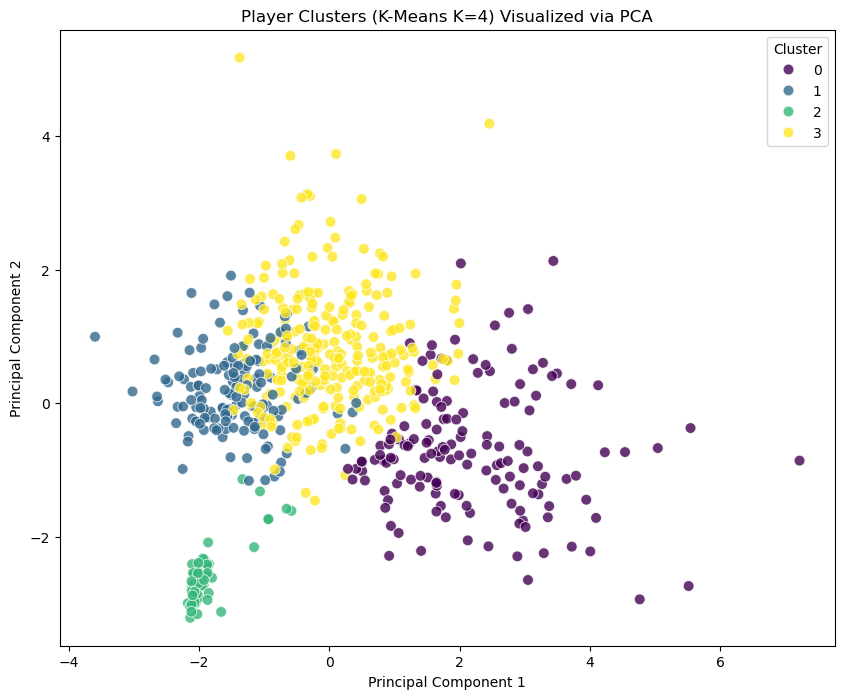

In [31]:
# Reduce dimensions using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Create a plot dataframe
df_plot = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=X.index)
df_plot['cluster'] = ucl_kmeans['cluster_label']
df_plot['position'] = ucl_kmeans['position']

# Plot Clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='cluster', data=df_plot, palette='viridis', s=60, alpha=0.8)
plt.title(f'Player Clusters (K-Means K={k}) Visualized via PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()

### Analysis of PC1 and PC2

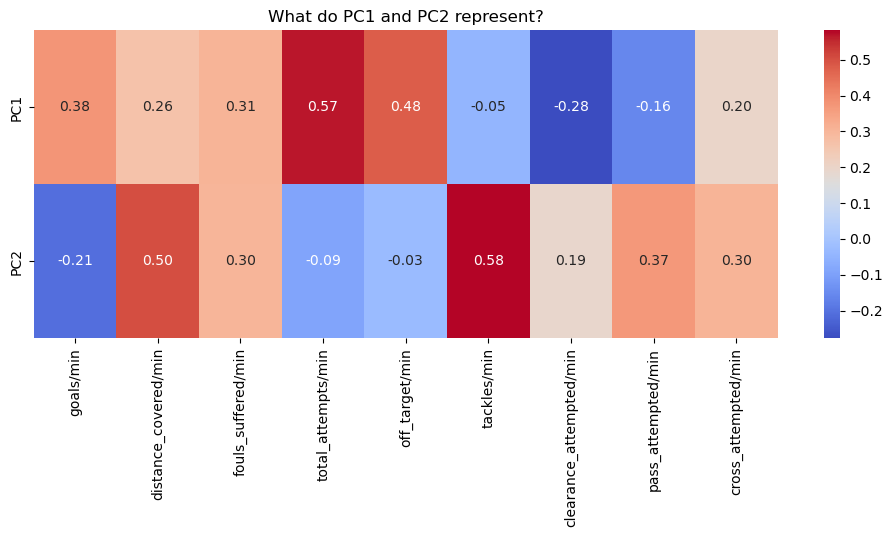

In [32]:
# Create a dataframe of the PCA components (Loadings)
components_df = pd.DataFrame(
    pca.components_, 
    columns=features, 
    index=['PC1', 'PC2']
)

# Plot a heatmap to make it easy to read
plt.figure(figsize=(12, 4))
sns.heatmap(components_df, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('What do PC1 and PC2 represent?')
plt.show()

Here's what we think the two PCA axes represent:

PCA1: "Attacking Agression vs Defensive Safety"
- Why: The highest positive values are total_attempts (0.57), off_target (0.48), and goals (0.38). The strongest negative value is clearance_attempted (-.28)
- Interpretation: As you move right on the X-axis (PC1), players become significantly more aggressive in front of the goal. As you move left, players are primarily responsible for clearing the bal away from danger. This axis effectively separates our Strikers from our Center Backs.

PCA2: "Work Rate & Ball Winning"
- Why: The highest positive values are tackles (0.58) and distance_covered(0.50), followed by pass_attempted (0.37).
- Interpretation: This axis measures how "busy" a player is. High values indicate players who run significantly more distance, engage in physical duels (tackles), and circulate the ball. This axis helps separate "Box-to-Box" midfielders and active Fullbacks (High PC2) from Goalkeepers and low-work-rate poachers (Low PC2)

### Analysis - Cross Tabulation
See how the unsupervised clusters compare to the actual positions

In [33]:
# Compare Clusters to Actual Positions
crosstab = pd.crosstab(ucl_kmeans['cluster_label'], ucl_kmeans['position'])
print("Cluster vs. Actual Position Distribution:")
display(crosstab)

# Compare Clusters to Binary Position (Def vs Off)
crosstab_binary = pd.crosstab(ucl_kmeans['cluster_label'], ucl_kmeans['position_binary'])
print("\nCluster vs. Binary Position (0=Def, 1=Off):")
display(crosstab_binary)

Cluster vs. Actual Position Distribution:


position,Defender,Forward,Goalkeeper,Midfielder
cluster_label,,,,
0,6,90,0,53
1,134,1,0,16
2,3,4,51,0
3,82,36,0,166



Cluster vs. Binary Position (0=Def, 1=Off):


position_binary,0,1
cluster_label,,
0,6,143
1,134,17
2,54,4
3,82,202


From this, we can see:


**Cluster 0:** The Attackers. (92 forwards, 54 midfielders): goal scorers and wingers

**Cluster 1:** Pure Defenders. (134 defenders, almost no forwards): likely our center backs and defensive specialists who focus on clearances and tackles

**Cluster 2:** The Engines / Playmakers. (165 Mids, 82 Defenders, 34 Forwards). Very interesting: it groups midfielders with a large chunk of defenders (likely fullbacks like Trent Alexander-Arnold or Hakimi) and some forwards. This suggests these players share a role of "ball progression" rather than just shooting or just clearing.

**Cluster 3:** Goalkeepers. (51 GKs, almost no one else): obvious because they have very low running distance, shots, and tackles compared to outfield players

### Finding Outliers / Hybrid Players
Identify players who are listed as Defenders but grouped into an Attacking cluster

In [42]:
attacking_cluster = 0 # This cluster represents whichever one looks like it's the strikers, so cluster 0

# Find Defenders in the Attacking Cluster
attacking_defenders = ucl_kmeans[
    (ucl_kmeans['cluster_label'] == attacking_cluster) & 
    (ucl_kmeans['position'] == 'Defender')
]

print(f"Defenders found in Attacking Cluster:")
display(attacking_defenders[['player_name', 'club', 'goals', 'total_attempts', 'distance_covered']])

Defenders found in Attacking Cluster:


,player_name,club,goals,total_attempts,distance_covered
19,Miguel Gutiérrez,Real Madrid,0,1.0,7.7
501,Chilwell,Chelsea,0,8.0,23.3
518,Chalobah,Chelsea,1,3.0,20.4
589,Ranocchia,Inter,0,2.0,10.9
619,Florenzi,Milan,0,3.0,12.6
625,Korniienko,Shakhtar Donetsk,0,1.0,11.2


### Digging deeper into cluster 2 (hybrid)

In [35]:
# Filter for Defenders who fell into Cluster 2 (The "Midfield/Engine" cluster)
hybrid_defenders = ucl_kmeans[
    (ucl_kmeans['cluster_label'] == 2) & 
    (ucl_kmeans['position'] == 'Defender')
]

print("Defenders playing like Midfielders (Cluster 2):")
# Displaying name and passing/crossing stats to see if they are playmakers
display(hybrid_defenders[['player_name', 'club', 'pass_attempted/min', 'cross_attempted/min', 'distance_covered/min']].head(10))

Defenders playing like Midfielders (Cluster 2):


,player_name,club,pass_attempted/min,cross_attempted/min,distance_covered/min
72,Reinildo,LOSC,0.446078,0.012255,0.108824
637,Emre Can,Dortmund,0.000000,0.000000,0.113514
649,Rúben Vinagre,Sporting CP,0.000000,0.000000,0.123810


In [36]:
# Find Defenders in the Attacking Cluster (cluster 0)
attacking_defenders = ucl_kmeans[
    (ucl_kmeans['cluster_label'] == 0) & 
    (ucl_kmeans['position'] == 'Defender') 
]

print(f"Defenders found in Attacking Cluster {attacking_cluster}:")
display(attacking_defenders[['player_name', 'club', 'goals', 'total_attempts', 'distance_covered']])

Defenders found in Attacking Cluster 0:


,player_name,club,goals,total_attempts,distance_covered
19,Miguel Gutiérrez,Real Madrid,0,1.0,7.7
501,Chilwell,Chelsea,0,8.0,23.3
518,Chalobah,Chelsea,1,3.0,20.4
589,Ranocchia,Inter,0,2.0,10.9
619,Florenzi,Milan,0,3.0,12.6
625,Korniienko,Shakhtar Donetsk,0,1.0,11.2


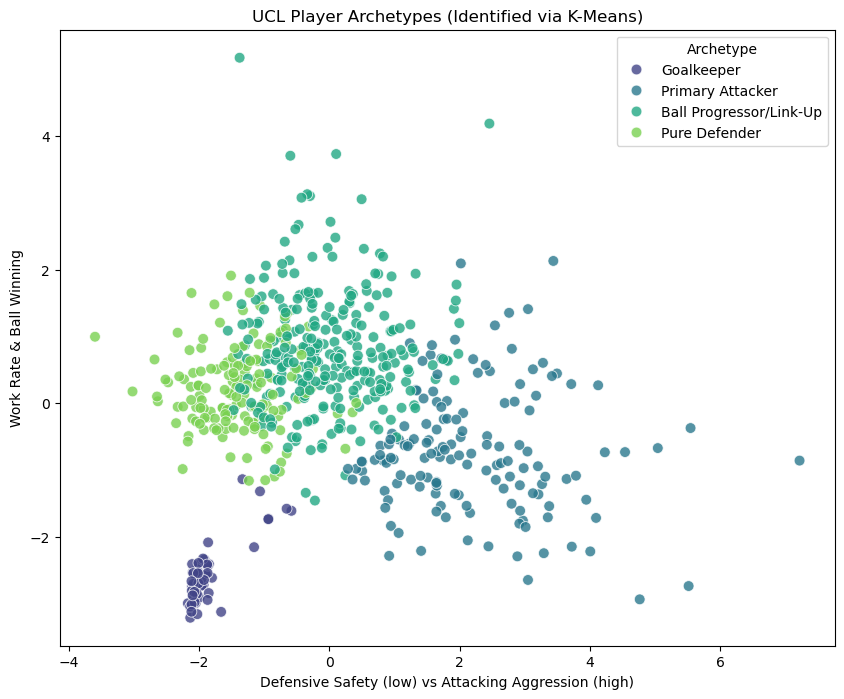

In [41]:
# Create a new column with string labels
ucl_kmeans['Archetype'] = ucl_kmeans['cluster_label'].map({
    0: 'Primary Attacker',
    1: 'Pure Defender',
    2: 'Goalkeeper',
    3: 'Ball Progressor/Link-Up'
})

# Add the PCA columns into this dataframe
# df_plot was created earlier and holds the PC1/PC2 values
ucl_kmeans['PC1'] = df_plot['PC1']
ucl_kmeans['PC2'] = df_plot['PC2']

# Running the scatter plot
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Archetype', data=ucl_kmeans, palette='viridis', s=60, alpha=0.8)
plt.title('UCL Player Archetypes (Identified via K-Means)')
plt.xlabel("Defensive Safety (low) vs Attacking Aggression (high)")
plt.ylabel("Work Rate & Ball Winning")
plt.show()